In [ ]:
import os
import sys
import warnings

sys.path.insert(1,os.getcwd()+"//..//retrieval//")

warnings.filterwarnings("ignore")

import datetime
import numpy as np
import pandas as pd
import pickle
import xarray as xr

get_ipython().run_line_magic('matplotlib', 'inline')
from scipy.stats import pearsonr
import PAMTRA_sim_analysis
import pyPamtra
import Regression_Retrieval
import PAMTRA_sim_analysis

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

### Path definitions

In [2]:
import os 
plot_path=os.getcwd()+"/plots/"
take_all_days=True
take_testing=False
take_random_days=False
take_snd_random_days=False
take_haloac3_day=False
ar_plot_path=plot_path+"synth_ARs/"
if take_testing:
    ar_plot_path=plot_path+"testing_cases/"
else:
    if take_random_days:
        ar_plot_path=plot_path+"rand_days/"
        if take_snd_random_days:
            ar_plot_path=plot_path+"snd_rand_days/"
    if take_haloac3_day:
        ar_plot_path=ar_plot_path+"/../halo_ac3/"
    if take_all_days:
        ar_plot_path=plot_path+"new_all_days/"
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)
if not os.path.exists(ar_plot_path):
    os.makedirs(ar_plot_path)
    print(ar_plot_path)
hour="12"
obs_height=12000

In [3]:
var_to_retrieve="q"
# Dataset Training sample
#synth_ar_dates=["20110317","20110423","20150314",
#                "20160311","20180224",
#                "20180225","20190319",
#                "20200416","20200419"
#                   ]
synth_ar_dates=['19790312', '19810330', '19810424',# '19820320', '19820416',# '19830316', '19830331', '19830414', 
    #'19840308', '19840413', '19840428', '19880330', '19890422', '19900409', '19900411', '19900418', 
    #'19910301', '19910428', '19920302',
    #'19920413', '19930303', '19930430', '19940421', '19950306', 
    #'19950317', '19970322', '19980324', '19980409', '20030415', '20050401', '20060317', '20070324',
    #'20080313', '20080404', '20080411', '20080430', '20090324', '20100323', '20110311', '20110329', 
    #'20110413', '20140309', '20140330', '20160409', '20180319', '20180326', '20200326', 
    
                #            '20220315', 
    #'20220316', '20220410'
    ]
if take_all_days:
    PAMTRASIM_analysis=PAMTRA_sim_analysis.PAMTRASIM_analysis
    synth_ar_dates=PAMTRASIM_analysis.list_all_simulated_days(hour=hour) # --> just testing
    # --< to be used for running synth_ar_dates=PAMTRASIM_analysis.list_all_simulated_days(data_path="/work/bb1320/hdorff/pamtra_hamp_retrieval/",hour=hour)
if take_haloac3_day:
    synth_ar_dates=["20220315"]
# add noise for TBs
add_noise=True

regridded_era5_ds_dict={}


5  days are already simulated
['20110317', '20110423', '20160311', '20180224', '20180225']


In [4]:
def merge_era5_quantities(synth_ar_dates):
    for d,date in enumerate(synth_ar_dates):
        print(date)
        sim_cls=sim_cls=PAMTRA_sim_analysis.PAMTRASIM_analysis(date=date,hour=hour)
        sim_cls.open_era5_ocean_fields()
    
        #Regrid ERA5 to unified grid
        #interpolate ERA5 data onto regular height grid
        sim_cls.create_regridded_era5()
        ### Calc specific humidity q for regridded era5
        sim_cls.regridded_era5=sim_cls.calc_specific_humidity_from_relative_humidity(sim_cls.regridded_era5)
        sim_cls.regridded_era5["idx"]=sim_cls.regridded_era5["idx"]+int(date)*1000
        regridded_era5_ds_dict[date]=sim_cls.regridded_era5
    merged_regridded_era5=xr.concat([*regridded_era5_ds_dict.values()],dim="idx")
    return merged_regridded_era5

def get_merged_tbs_at_obs_height(synth_ar_dates,height):
    PAMTRASIM_analysis=PAMTRA_sim_analysis.PAMTRASIM_analysis
    
    for d,date_to_analyse in enumerate(synth_ar_dates):
        print(date_to_analyse)
        tmp_sim_cls=PAMTRASIM_analysis(date=date_to_analyse,hour=hour)    
        tmp_sim_cls.open_pamtra_tbs_ocean()
        output_heights=pd.Series(data=np.array(tmp_sim_cls.pamtra_ds.obs_height.values))
        relevant_height_idx=int(output_heights.index[output_heights == height].values[0])#.tolist()output_heights.get_loc()
        tmp_sim_cls.tb_da=tmp_sim_cls.tb_da.isel({"nout":relevant_height_idx})
        temp_df=pd.DataFrame(data=tmp_sim_cls.tb_da.values,
                         columns=tmp_sim_cls.tb_da.freq)
        temp_df.index=temp_df.index+int(date_to_analyse)*1000 
        temp_df["Date"]=date_to_analyse
        if d==0:
            tb_df=temp_df
        else:
            tb_df=pd.concat([tb_df,temp_df])

    del tb_df[182.71]
    return tb_df,tmp_sim_cls

def add_noise_to_synth_TBs(tb_df):
    # add noise to PAMTRA TBs
    # create randomn vector
    # k,v band noise 0:14
    for kv_band_freq in range(14):
        random_noise=np.random.random_sample(tb_df.shape[0])
        values=pd.Series(data=-0.25 + 0.5*random_noise,index=tb_df.index)
        tb_df.iloc[:,kv_band_freq]=tb_df.iloc[:,kv_band_freq]+values
    
    for other_freq in np.arange(14,int(tb_df.shape[1]-1)):
        random_noise=np.random.random_sample(tb_df.shape[0])
        values=pd.Series(data=-0.5 + 1.0*random_noise,index=tb_df.index)
        tb_df.iloc[:,other_freq]=tb_df.iloc[:,other_freq]+values

    return tb_df
        #pass

### Regrid ERA5 to unified grid

In [5]:
merged_regridded_era5=merge_era5_quantities(synth_ar_dates)

if var_to_retrieve=="log_q":
    merged_regridded_era5["log_q"]=np.log(merged_regridded_era5["q"])
merged_regridded_era5

20110317
Regrid  t
[####################] 100% Regrid  p
[####################] 100% Regrid  rh
[####################] 100% mixing_ratio calculated
specific humidity calculated
20110423
Regrid  t
[####################] 100% Regrid  p
[####################] 100% Regrid  rh
[####################] 100% mixing_ratio calculated
specific humidity calculated
20160311
Regrid  t
[####################] 100% Regrid  p
[####################] 100% Regrid  rh
[####################] 100% mixing_ratio calculated
specific humidity calculated
20180224
Regrid  t
[####################] 100% Regrid  p
[####################] 100% Regrid  rh
[####################] 100% mixing_ratio calculated
specific humidity calculated
20180225
Regrid  t
[####################] 100% Regrid  p
[####################] 100% Regrid  rh
[####################] 100% mixing_ratio calculated
specific humidity calculated


<xarray.Dataset>
Dimensions:  (z: 531, idx: 2900)
Coordinates:
  * z        (z) float64 0.0 30.0 60.0 90.0 ... 1.584e+04 1.587e+04 1.59e+04
  * idx      (idx) int64 20110317000 20110317001 ... 20180225621 20180225622
Data variables:
    lat      (idx) float64 66.46 65.34 66.46 65.34 ... 74.33 73.21 72.08 70.96
    lon      (idx) float64 -29.81 -29.81 -28.69 -28.69 ... 48.94 48.94 48.94
    t        (idx, z) float64 259.9 259.2 258.6 258.3 ... 225.2 nan nan nan
    p        (idx, z) float64 9.916e+04 9.877e+04 9.837e+04 ... nan nan nan
    rh       (idx, z) float64 49.95 38.4 38.69 37.91 37.5 ... 0.5636 nan nan nan
    q        (idx, z) float32 0.0006939 0.0005058 0.0004888 ... nan nan nan

### Get PAMTRA-HAMP TBs

In [6]:
height=12000
obs_heights=[16000., 15400.,15200.,15000.,14800.,14600.,14400.,14200.,14000.,13800.,13600.,
            13400,13200,13000,12800,12600,12400,12200,12000., 
            #11800.,11600.,11400.,
            #11200.,11000.,10800.,10600.,10400.,10200.,10000.,9800.,9600.,9400.,9200.,
            #9000., 8800.,8600.,8400.,8200.,8000.,7800.,7600.,7400.,7200.,7000.
            ]

for height in obs_heights:
    tb_df,sim_cls=get_merged_tbs_at_obs_height(synth_ar_dates,height)
    if add_noise:
        print("add noise to bright band temperatures")
        tb_df=add_noise_to_synth_TBs(tb_df)
    else:
        print("Caution: No noise added to PAMTRA TBs")
    
    #Vertical Regression Retrieval
    retrieval=Regression_Retrieval.Regression_Retrieval
    order=2
    brightness_Ts=tb_df.copy()
    #sim_cls.regridded_era5
    if len(synth_ar_dates)>1:
        era5_ds=merged_regridded_era5
    else:
        era5_ds=sim_cls.regridded_era5
    Retrieval=retrieval(era5_ds,var_to_retrieve,brightness_Ts,order,synth_ar_dates,ar_plot_path,added_noise=True,
                       obs_height=height)
    Retrieval.get_vertical_m_est(era5_ds)

20110317
20110423
20160311
20180224
20180225
add noise to bright band temperatures
Retrieve  q  via Regression
Height Regression
[####################] 100% Retrieval coeffs saved as: /home/u/u300737/era5_hamp_pamtra/hamp_retrieval_haloac3/notebooks/plots/new_all_days/q_Retrieval_coeffs_several_dates_16000.csv
20110317
20110423
20160311
20180224
20180225
add noise to bright band temperatures
Retrieve  q  via Regression
Height Regression
[####################] 100% Retrieval coeffs saved as: /home/u/u300737/era5_hamp_pamtra/hamp_retrieval_haloac3/notebooks/plots/new_all_days/q_Retrieval_coeffs_several_dates_15400.csv
20110317
20110423
20160311
20180224
20180225
add noise to bright band temperatures
Retrieve  q  via Regression
Height Regression
[####################] 100% Retrieval coeffs saved as: /home/u/u300737/era5_hamp_pamtra/hamp_retrieval_haloac3/notebooks/plots/new_all_days/q_Retrieval_coeffs_several_dates_15200.csv
20110317
20110423
20160311
20180224
20180225
add noise to bright

## Vertical Regression Retrieval

In [7]:
#Retrieval.height_m_est
#brightness_Ts["Date"].unique()

In [8]:
date="19890422"#20150314"
test_sim_cls=sim_cls=PAMTRA_sim_analysis.PAMTRASIM_analysis(data_path="/work/bb1320/hdorff/pamtra_hamp_retrieval/",date=date,hour="12")
test_sim_cls.open_era5_ocean_fields()
test_era5_ds=test_sim_cls.era5_ds
test_sim_cls.create_regridded_era5()
regridded_test_era5=sim_cls.regridded_era5
regridded_test_era5=sim_cls.calc_specific_humidity_from_relative_humidity(regridded_test_era5)
test_sim_cls.regridded_era5=regridded_test_era5
regridded_test_era5

Regrid  t
[####################] 100% Regrid  p
[####################] 100% Regrid  rh
[####################] 100% mixing_ratio calculated
specific humidity calculated


<xarray.Dataset>
Dimensions:  (idx: 464, z: 534)
Coordinates:
  * idx      (idx) int64 0 1 2 3 4 5 6 7 8 ... 456 457 458 459 460 461 462 463
  * z        (z) float64 0.0 30.0 60.0 90.0 ... 1.593e+04 1.596e+04 1.599e+04
Data variables:
    lat      (idx) float64 65.34 65.34 65.34 65.34 ... 74.33 73.21 72.08 70.96
    lon      (idx) float64 -29.81 -28.69 -27.56 -26.44 ... 48.94 48.94 48.94
    t        (idx, z) float64 274.9 274.6 274.3 274.1 ... 222.6 222.5 222.5
    p        (idx, z) float64 1.039e+05 1.035e+05 ... 1.05e+04 1.045e+04
    rh       (idx, z) float64 68.56 69.1 69.87 70.81 ... 0.6998 0.7006 0.7014
    q        (idx, z) float32 0.002856 0.002825 0.002812 ... 2.463e-06 2.466e-06

### Test run

In [25]:
test_sim_cls.open_pamtra_tbs_ocean()
heights_series=pd.Series(obs_heights)
h=heights_series.iloc[heights_series.values==obs_height].index
height_tbs=np.squeeze(sim_cls.tb_da.isel(nout=h).values,axis=1)
temp_df=pd.DataFrame(data=height_tbs,columns=test_sim_cls.tb_da.freq)
test_TBs=temp_df.iloc[200:202,:]
test_TBs["Date"]=date
del test_TBs[182.71]
## Built K
if var_to_retrieve=="log_q":
    regridded_test_era5["log_q"]=np.log(regridded_test_era5["q"])
    state_vector=regridded_test_era5["log_q"][200:202,:]
else:
    state_vector=regridded_test_era5[var_to_retrieve][200:202,:]*1000
state_vector
Retrieval=retrieval(state_vector,var_to_retrieve,test_TBs,2,
                    ["20150314"],ar_plot_path)
Retrieval.build_K_reg()
# Retrieval coeffs
if len(synth_ar_dates)==1:
    coeff_file=var_to_retrieve+"_Retrieval_coeffs_20110317.csv"
    if take_haloac3_day:
        coeff_file=var_to_retrieve+"_Retrieval_coeffs_20220315.csv"
        print("HALO-AC3")
    m_est_heights=pd.read_csv(ar_plot_path+coeff_file,index_col=0)
else:
    m_est_heights=pd.read_csv(ar_plot_path+var_to_retrieve+"_Retrieval_coeffs_several_dates_"+str(int(obs_height))+".csv",index_col=0)
print("m-height",m_est_heights.shape)
#sys.exit()
# Create vertical q profile
var_retrieved=pd.DataFrame(data=np.nan, columns=["200","201"],index=regridded_test_era5["z"].values)
print("retrieval",Retrieval.K_reg.shape)
print("test_era5",regridded_test_era5["q"].shape)

if len(synth_ar_dates)>1:
    for z in range(m_est_heights.shape[0]):#regridded_test_era5["z"].shape[0]):
        var_retrieved.iloc[z,:]=m_est_heights.iloc[z,:].dot(Retrieval.K_reg.T)
else:
    for z in range(m_est_heights.shape[0]):
        m_coeffs=m_est_heights.iloc[z,:]
        var_retrieved.iloc[z,:]=m_coeffs.dot(Retrieval.K_reg.T)

if var_to_retrieve=="q":
    var_retrieved*=1000 

print(var_to_retrieve,":",var_retrieved)

m-height (531, 51)
retrieval (2, 51)
test_era5 (464, 534)
q :               200       201
0.0      1.701962  2.029270
30.0     1.591904  1.916321
60.0     1.524304  1.840623
90.0     1.486900  1.796582
120.0    1.459128  1.762883
...           ...       ...
15870.0       NaN       NaN
15900.0       NaN       NaN
15930.0       NaN       NaN
15960.0       NaN       NaN
15990.0       NaN       NaN

[534 rows x 2 columns]


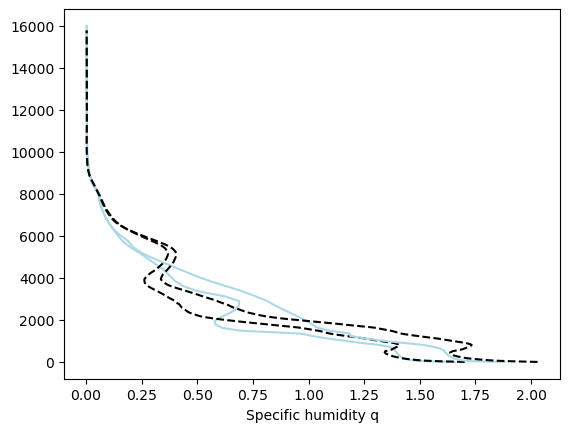

In [26]:
for idx in np.arange(200,202):
    if var_to_retrieve=="q":
        plt.plot(regridded_test_era5[var_to_retrieve][idx,:]*1000,regridded_test_era5["z"],color="lightblue")
        plt.plot(var_retrieved.iloc[:,idx-200],regridded_test_era5["z"],color="k",ls="--")
        plt.xlabel("Specific humidity q")
    elif var_to_retrieve=="log_q":
        plt.plot(np.exp(regridded_test_era5[var_to_retrieve][idx,:])*1000,regridded_test_era5["z"],color="lightblue")
        plt.plot(np.exp(var_retrieved.iloc[:,idx-200])*1000,regridded_test_era5["z"],color="k",ls="--")
        plt.xlabel("Specific humidity q")
    else:
        plt.plot(regridded_test_era5[var_to_retrieve][idx,:],regridded_test_era5["z"],color="lightblue")
        plt.plot(var_retrieved.iloc[:,idx-200],regridded_test_era5["z"],color="k",ls="--")
        plt.xlabel("Temperature K")

In [31]:
if var_to_retrieve=="q":
    var_retrieved=var_retrieved.dropna()
    iwv=1/1.000*np.trapz(var_retrieved,axis=0,x=var_retrieved.index)/1000
    print("retrieved IWV",iwv)
    ##def calc_iwv_from_q(q_loc):
    ##    iwv_temporary=-1/g*np.trapz(q_loc,axis=0,x=pres_index)
    print("era5:",test_sim_cls.era5_ds["iwv"][200:202,0,0].values)            

retrieved IWV [4.11819823 5.19383289]
era5: [4.31414628 5.37353134]
